In [2]:
#im skipping leap days currently in multiple places
import sys
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import seaborn
import random
import json
import pickle
import time
import copy

import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%load_ext autoreload
%autoreload 2
%matplotlib inline

#train neural network on load and weather features
#identify annual, then monthly CP's
#include load forecast as feature

In [3]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [4]:
#ercot 2017 loads

path = "/home/chase/projects/peakload/data/ercot/"
ercot2017 = pd.read_excel(path + "native_Load_2017.xlsx")

testloads = np.array(list(ercot2017['ERCOT']))

In [5]:
startdate = datetime.datetime(year=2010, month=1, day=1, hour=0, minute=0, second=0)
curr = startdate
enddate = datetime.datetime(year=2018, month=1, day=1, hour=0, minute=0, second=0)

allhours = []

while curr < enddate:
    allhours.append(curr)
    curr += datetime.timedelta(hours=1)
    
trainhours = np.array(allhours[0:-8760]) #all but last year, not a leap year
testhours = np.array(allhours[-8760:])

#get indecies of day starts in testhours
startdate = datetime.datetime(year=2017, month=1, day=1, hour=0, minute=0, second=0)
curr = startdate
enddate = datetime.datetime(year=2018, month=1, day=1, hour=0, minute=0, second=0)

day_start_i = []
i = 0

while curr < enddate:
    if curr.hour == 0:
        day_start_i.append(i)
    curr += datetime.timedelta(hours=1)
    i += 1

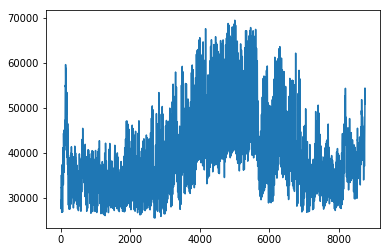

array([datetime.datetime(2017, 7, 28, 15, 0),
       datetime.datetime(2017, 7, 28, 16, 0),
       datetime.datetime(2017, 7, 28, 14, 0),
       datetime.datetime(2017, 7, 20, 15, 0),
       datetime.datetime(2017, 7, 27, 15, 0)], dtype=object)

In [6]:
#July peak was calculated to have occured at datetime.datetime(2017, 7, 28, 17, 0)

plt.plot(testloads)
plt.show()
testhours[testloads.argsort()[-5:][::-1]]

570.2781314827672 36556.57900951147


/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


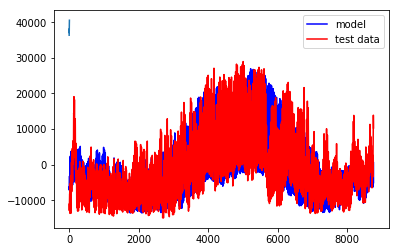

In [39]:
#ERCOT data
subregions = ['COAST', 'EAST', 'FAR_WEST', 'NORTH', 'NORTH_C', 'SOUTHERN', 'SOUTH_C', 'WEST', 'ERCOT']
other_subregions = ['COAST', 'EAST', 'FWEST', 'NORTH', 'NCENT', 'SOUTH', 'SCENT', 'WEST', 'ERCOT']

lds = datetime.datetime(year=2016, month=2, day=29, hour=0, minute=0) #lines 1415 to 1439
lde = datetime.datetime(year=2016, month=2, day=29, hour=23, minute=0)

path = "/home/chase/projects/peakload/data/ercot/"
ercot2017 = pd.read_excel(path + "native_Load_2017.xlsx")
ercot2016 = pd.read_excel(path + "native_Load_2016.xlsx") #leap year
ercot2016.drop(ercot2016.index[1415:1439], inplace=True) #dropping leap days so years line up

ercot2015 = pd.read_excel(path + "native_Load_2015.xls")
ercot2014 = pd.read_excel(path + "2014_ERCOT_Hourly_Load_Data.xls")
ercot2013 = pd.read_excel(path + "2013_ERCOT_Hourly_Load_Data.xls")
ercot2012 = pd.read_excel(path + "2012_ERCOT_Hourly_Load_Data.xls") #leap year
ercot2012.drop(ercot2012.index[1415:1439], inplace=True)

ercot2011 = pd.read_excel(path + "2011_ERCOT_Hourly_Load_Data.xls")
ercot2010 = pd.read_excel(path + "2010_ERCOT_Hourly_Load_Data.xls")

yearly_data = [ercot2010, ercot2011, ercot2012, ercot2013, ercot2014, ercot2015, ercot2016, ercot2017]
training = [list(ercot2010['ERCOT']), list(ercot2011['ERCOT']), list(ercot2012['ERCOT']), list(ercot2013['ERCOT']), list(ercot2014['ERCOT']), list(ercot2015['ERCOT']), list(ercot2016['ERCOT'])]
means = [ np.nanmean(y) for y in training ]

#use system-wide loadgrowth for all regions
A = np.vstack((np.array([0, 1, 2, 3, 4, 5, 6]), np.array([1, 1, 1, 1, 1, 1, 1]))).T
a, b = np.linalg.lstsq(A, np.array(means))[0]
print(a, b)
projected_mean = a*7.0 + b
plt.plot(means + [projected_mean])
means.append(projected_mean)
load_growth = np.array(means)

yearly_loads = np.zeros((8,8760))
unshifted_yearly_loads = np.zeros((8,8760))

for i in range(len(yearly_data)):
    yearly_loads[i,:] = np.array(yearly_data[i]['ERCOT']) - load_growth[i]
    unshifted_yearly_loads[i,:] = np.array(yearly_data[i]['ERCOT'])
    
model = np.nanmean(yearly_loads[0:6,:], axis=0)
test = yearly_loads[7,:]
plt.plot(model, color="blue", label="model")
plt.plot(test, color="red", label="test data")
plt.legend()
plt.show()

In [8]:
np.where(np.isnan(yearly_loads))

(array([6]), array([7439]))

In [40]:
month_blocks = {}
unshifted_month_blocks = {}
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
days_month = {0:0, 1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
for j in range(len(years)):
    year_index = j*8760
    for i in range(12):
        month = i+1
        year = years[j]
        day_of_year = 0
        for k in range(month):
            day_of_year += days_month[k]
        num_days = days_month[month]
        month_blocks[str(year) + "_" + str(month)] = yearly_loads[j,day_of_year*24:(day_of_year + num_days)*24]
        unshifted_month_blocks[str(year) + "_" + str(month)] = unshifted_yearly_loads[j,day_of_year*24:(day_of_year + num_days)*24]

744
[-4562.15432058 -5044.02072758 -5051.43227458]
[ -9357.45056807  -9904.55947407 -10017.92332307]
[-10328.81390424 -11530.79399424 -12290.83391824]
[-10821.88801312 -11708.54320112 -12265.42862712]
[-11512.69952023 -12570.06906923 -13068.06465023]
[-8011.93364803 -8881.14192503 -9110.99513003]
[-9036.88307352 -9633.28225452 -9753.88428352]
[-10248.19125789 -11143.17237889 -11627.76074789]


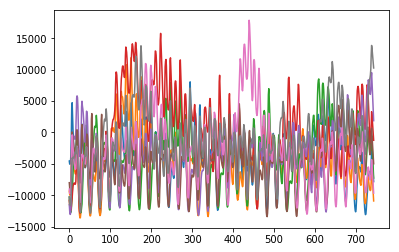

In [10]:
month = 12

print(len(month_blocks[str(years[0]) + "_" + str(month)]))

for y in years:
    plt.plot(month_blocks[str(y) + "_" + str(month)])
    print(month_blocks[str(y) + "_" + str(month)][0:3])
    
plt.show()

In [11]:
#generate CDF for each month, create time series of CDF values

In [12]:
month_CDF_labels = {}

for y in years:
    for month in range(12):
        month += 1
        month_CDF_labels[str(y) + "_" + str(month)] = []
        demands = month_blocks[str(y) + "_" + str(month)]
        
        for j in range(len(month_blocks[str(y) + "_" + str(month)])):
            greater = np.sum([1 for k in demands if k >= demands[j]])/float(len(demands))
            month_CDF_labels[str(y) + "_" + str(month)].append(1.0 - greater)

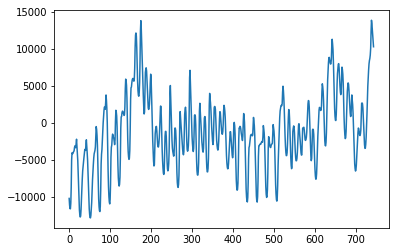

In [13]:
plt.plot(month_blocks[str(y) + "_12"])
plt.show()

In [14]:
#save label dictionary

outdir = "/home/chase/projects/peakload/data/ercot/monthly/monthly_CP_labels.pck"

with open(outdir, 'wb') as d:
    pickle.dump(month_CDF_labels, d)

In [51]:
#I want to look at June, July, August, September CDF's
summer_months = [6, 7, 8, 9] #starts at 1
peaks = np.zeros((4,8))
diffs = []
for j in range(len(summer_months)):
    month = summer_months[j]
    month_array = np.zeros((8, len(month_blocks['2010_' + str(month)])))

    for i in range(len(years)):
        y = years[i]
        month_array[i,:] = np.sort(np.asarray(month_blocks[str(y) + '_' + str(month)]))

        peaks[j,i] = np.max(unshifted_month_blocks[str(y) + "_" + str(month)])
        
    diffs.append(month_array[:,-1] - month_array[:,-2])
    


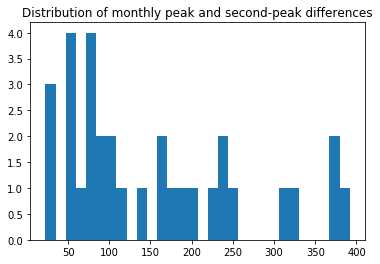

In [26]:
plt.hist(np.asarray(diffs).flatten(), bins=30)
plt.title("Distribution of monthly peak and second-peak differences")
plt.show()

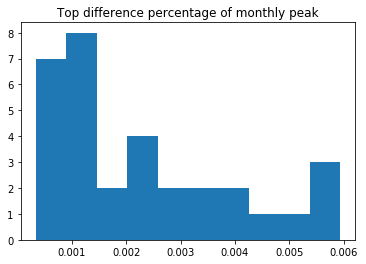

0.005934311701904249


In [70]:
#what is percentage of top difference of peak load?
diffs = np.asarray(diffs)

perc_resp = diffs/peaks
plt.hist(perc_resp.flatten())
plt.title("Top difference percentage of monthly peak")
plt.show()

print(np.max(perc_resp))

In [61]:
#distribution of CP demands in 2017

cps2017 = pd.read_excel("/home/chase/projects/peakload/data/ercot/fourcp2017.xlsx")

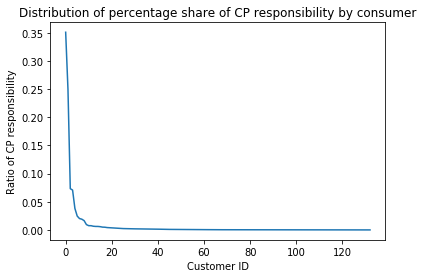

117 or 87.96992481203007% of customers under 0.5%, make up total market share of:  8.79808
89 or 66.9172932330827% of customers under 0.1%, make up total market share of:  2.2848699999999997


In [83]:
perc_share = np.asarray(list(cps2017["Load Ratio Share"]))[0:133]
plt.plot(np.sort(perc_share)[::-1])
plt.title("Distribution of percentage share of CP responsibility by consumer")
plt.ylabel("Ratio of CP responsibility")
plt.xlabel("Customer ID")
plt.show()

print(str(len(perc_share[perc_share < 0.005])) + " or " + str(len(perc_share[perc_share < 0.005])/len(perc_share) * 100) + "% of customers under 0.5%, make up total market share of: ", np.sum(perc_share[perc_share < 0.005]) * 100)
print(str(len(perc_share[perc_share < 0.001])) + " or " + str(len(perc_share[perc_share < 0.001])/len(perc_share) * 100) + "% of customers under 0.1%, make up total market share of: ", np.sum(perc_share[perc_share < 0.001]) * 100)


array([2.0816e-03, 6.7390e-04, 3.9550e-04, 3.4000e-06, 3.9080e-03,
       4.9536e-03, 1.9080e-03, 5.2100e-05, 7.9590e-04, 3.8700e-05,
       2.4630e-04, 1.9380e-04, 4.7650e-04, 2.2500e-04, 2.1340e-04,
       8.3920e-04, 1.8340e-04, 2.6900e-04, 1.2910e-04, 2.9102e-03,
       3.0940e-04, 1.0370e-04, 8.1200e-05, 4.8960e-04, 2.1459e-03,
       1.8910e-04, 1.2600e-05, 7.2000e-05, 2.7610e-04, 1.3660e-04,
       1.5800e-04, 1.7760e-04, 2.3680e-04, 3.4200e-04, 4.1200e-05,
       1.5370e-04, 3.8650e-04, 1.8470e-04, 7.9600e-05, 3.4900e-05,
       3.0810e-04, 1.8594e-03, 1.3600e-04, 2.1190e-04, 1.9880e-04,
       9.4650e-04, 1.0470e-04, 1.3960e-04, 1.4630e-04, 6.8400e-05,
       1.1540e-04, 1.2570e-04, 2.8300e-04, 3.3810e-04, 7.4290e-04,
       8.5390e-04, 1.2359e-03, 8.7000e-06, 2.0050e-04, 4.7947e-03,
       0.0000e+00, 5.1770e-04, 1.7000e-05, 3.6992e-03, 1.0770e-04,
       1.1300e-05, 8.9490e-04, 3.3090e-04, 1.5432e-03, 2.9470e-04,
       1.8630e-04, 3.5199e-03, 1.0000e-05, 2.5700e-04, 5.2680e

In [63]:
cps2017["Load Ratio Share"]

0      0.073254
1      0.016468
2      0.002082
3      0.000674
4      0.000396
5      0.006537
6      0.000003
7      0.003908
8      0.004954
9      0.249324
10     0.001908
11     0.000052
12     0.000796
13     0.038214
14     0.000039
15     0.000246
16     0.000194
17     0.000476
18     0.000225
19     0.000213
20     0.000839
21     0.000183
22     0.000269
23     0.000129
24     0.002910
25     0.000309
26     0.000104
27     0.000081
28     0.000490
29     0.006172
         ...   
107    0.000672
108    0.000121
109    0.000128
110    0.000000
111    0.000072
112    0.002032
113    0.000000
114    0.000667
115    0.007493
116    0.000318
117    0.001106
118    0.000002
119    0.000002
120    0.000592
121    0.000001
122    0.000911
123    0.024616
124    0.009460
125    0.002486
126    0.000014
127    0.006191
128    0.001452
129    0.001338
130    0.000010
131    0.000564
132    0.001830
133    0.000060
134         NaN
135    1.000000
136         NaN
Name: Load Ratio Share, 

In [ ]:
#load data pairs, reduce number of features

In [27]:
#for subregions
vectorized_subregions = {}
for region in subregions:
    vectorized_subregions[region] = {}
    train_data_vec = np.array(yearly_data[region][0]) - np.mean(yearly_data[region][0])
    means = [np.mean(yearly_data[region][0])]
    for i in range(1, len(yearly_data[region])-1):
        yr = yearly_data[region][i]
        m = np.nanmean(yr)
        means.append(m)
        train_data_vec = np.concatenate((train_data_vec, np.array(yr)-m), axis=0)
        
    vectorized_subregions[region]['train_data'] = train_data_vec    
    vectorized_subregions[region]['means'] = means

TypeError: list indices must be integers or slices, not str

In [ ]:
for region in subregions:
    #if switching back to monthly labels output feature engineered data elsewhere
    #train_data_vec = vectorized_subregions[region]['train_data']
    
    train_data_vals = []
    #train_data_labels = []
    train_data_labels = np.array([])
    
    for i in range(len(yearly_data[region])-1):
        year_data = yearly_data[region][i]
        train_data_l = np.zeros((len(year_data),))
        for j in range(len(year_data)):
            greater = np.sum([1 for k in year_data if k >= year_data[j]])/float(len(year_data))
            train_data_l[j] = 1.0 - greater
        train_data_labels = np.concatenate((train_data_labels, train_data_l), axis=0)
            
    vectorized_subregions[region]['train_labels'] = train_data_labels